## Setup LLM as a Virtual Judge

In [1]:
import json
from typing import Optional

from ollama import chat
import pandas as pd
from pydantic import BaseModel, Field

In [2]:
def generate_virtual_judge_prompt(question: str, answer_true: str, answer_rag: str) -> str:
    prompt = f"""You are an expert evaluator assessing the quality of answers generated by 
a RAG (Retrieval-Augmented Generation) system. Your task is to compare a generated answer 
against a reference answer and provide a detailed evaluation.

Question: 
{question}

Reference Answer: 
{answer_true}

Generated Answer: 
{answer_rag}

Please evaluate the generated answer through the following steps:

Step 1: Analyze the factual accuracy by comparing specific claims in the generated answer against 
the reference answer. List which facts are correct and which (if any) are incorrect or misrepresented.

Step 2: Identify any important information from the reference answer that is missing in the 
generated answer.

Step 3: Determine if the generated answer contains any hallucinated information (claims 
not supported by the reference answer).

Step 4: Assess how directly the generated answer addresses the original question.

Based on your analysis, provide scores on a scale of 1-5 for each dimension:

Factual Accuracy (1-5):
1: Contains multiple factual errors
3: Contains minor inaccuracies
5: All facts are completely accurate

Completeness (1-5):
1: Missing most key information
3: Contains core information but omits some details
5: Covers all important information from the reference

Relevance (1-5):
1: Barely addresses the question
3: Addresses the main question but with tangential information
5: Directly and specifically answers the question

Hallucination (1-5):
1: Contains significant made-up information
3: Contains minor details not in the reference
5: No hallucinated content whatsoever

Finally, provide an Overall Score (1-5) that reflects the answer's overall quality, 
and a brief justification for your evaluation.

Overall Score (1-5):
Justification:
"""
    return prompt

In [3]:
class VirtualJudgeResponse(BaseModel):
    factual_accuracy: int = Field(
        description="Factual Accuracy (1-5)"
    )
    completeness: int = Field(
        description="Completeness (1-5)"
    )
    relevance: int = Field(
        description="Relevance (1-5)"
    )
    hallucination: int = Field(
        description="Hallucination (1-5)"
    )
    overall: int = Field(
        description="Overall Score (1-5)"
    )
    justification: str = Field(
        description="Justification for the evaluation"
    )

In [4]:
def judge_answer(
    question: str,
    answer_true: str,
    answer_rag: str,
    model: str ='llama3.1:latest'
) -> VirtualJudgeResponse:
    prompt = generate_virtual_judge_prompt(question, answer_true, answer_rag)
    
    response = chat(
        messages=[
            {
            'role': 'user',
            'content': prompt,
            }
        ],
        model=model,
        format=VirtualJudgeResponse.model_json_schema(),
    )
    response_structured = VirtualJudgeResponse.model_validate_json(
        response.message.content
    )
    return response_structured

### Eval test

In [5]:
input_ = generate_virtual_judge_prompt(
    question="What is the capital of France?",
    answer_true="The capital of France is Paris.",
    answer_rag="Paris is the capital of France."
)
print(input_)

You are an expert evaluator assessing the quality of answers generated by 
a RAG (Retrieval-Augmented Generation) system. Your task is to compare a generated answer 
against a reference answer and provide a detailed evaluation.

Question: 
What is the capital of France?

Reference Answer: 
The capital of France is Paris.

Generated Answer: 
Paris is the capital of France.

Please evaluate the generated answer through the following steps:

Step 1: Analyze the factual accuracy by comparing specific claims in the generated answer against 
the reference answer. List which facts are correct and which (if any) are incorrect or misrepresented.

Step 2: Identify any important information from the reference answer that is missing in the 
generated answer.

Step 3: Determine if the generated answer contains any hallucinated information (claims 
not supported by the reference answer).

Step 4: Assess how directly the generated answer addresses the original question.

Based on your analysis, provi

In [6]:
virtual_judge_response = judge_answer(
    question="What is the capital of France?",
    answer_true="The capital of France is Paris.",
    answer_rag="Paris is the capital of France."
)

In [7]:
print(json.dumps(virtual_judge_response.model_dump(), indent=4))

{
    "factual_accuracy": 5,
    "completeness": 4,
    "relevance": 5,
    "hallucination": 5,
    "overall": 4,
    "justification": "The generated answer accurately states the capital of France and is entirely correct. However, it lacks a minor detail in its completeness, as it does not explicitly state \u201cThe capital of France is\u201d. The relevance score reflects that it directly addresses the question with no tangential information."
}


## Generate answers from RAG system
### Load data

In [8]:
def load_and_prepare_eval_data(chunk_data_fp: str, eval_data_fp: str) -> pd.DataFrame:

    df_chunks = pd.read_parquet(chunk_data_fp)

    df_tmp = pd.read_json(eval_data_fp, lines=True)
    df_tmp_exploded = df_tmp.explode('qa_pairs')
    # expand and add question-answer columns
    df_eval = pd.concat([
        df_tmp_exploded.drop(columns=['qa_pairs']),
        df_tmp_exploded['qa_pairs'].apply(pd.Series),
    ], axis=1)
    # expand and add metadata columns, and merge original data
    df_eval = pd.concat([
        df_eval.drop(columns=['metadata']),
        df_eval['metadata'].apply(pd.Series),
    ], axis=1).merge(
        df_chunks[['id', 'doc_id', 'text', 'cluster_tsne', 'metadata']],
        on='id',
    )
    return df_eval

In [9]:
chunk_filepath = './data/eval_sampled.parquet'
eval_filepath = './data/qa_pairs_gemma.jsonl'
df_eval = load_and_prepare_eval_data(chunk_filepath, eval_filepath)
df_eval.head()

,idx,id,question,answer,question_type,difficulty,required_context,reasoning,q_a_quality,doc_id,text,cluster_tsne,metadata
0,783,871e39f3-ad80-413d-9353-93b39da8adf5,What is the primary function of a data connect...,A data connector (or 'Reader') ingests data fr...,factual,easy,basic understanding of terminology,This question directly asks for the role of a ...,good,aa4c9403-c960-442a-aca3-31ad8ae64f6e,## Concept\n\nA data connector (aka `Reader`) ...,0,"{'_node_content': '{""id_"": ""871e39f3-ad80-413d..."
1,783,871e39f3-ad80-413d-9353-93b39da8adf5,"According to the document, what are the typica...","After data ingestion, you can build an Index, ...",inferential,medium,understanding of workflow,This question requires the user to understand ...,good,aa4c9403-c960-442a-aca3-31ad8ae64f6e,## Concept\n\nA data connector (aka `Reader`) ...,0,"{'_node_content': '{""id_"": ""871e39f3-ad80-413d..."
2,783,871e39f3-ad80-413d-9353-93b39da8adf5,Explain the overall purpose of using data conn...,The purpose is to take data from various sourc...,analytical,hard,understanding of overall system architecture &...,This requires the user to synthesize the infor...,good,aa4c9403-c960-442a-aca3-31ad8ae64f6e,## Concept\n\nA data connector (aka `Reader`) ...,0,"{'_node_content': '{""id_"": ""871e39f3-ad80-413d..."
3,851,45e0ab38-6280-4862-be9f-b57ce7f96492,What is the primary subject matter described i...,Relation-Based Node Parsers,factual,easy,entire chunk,This question tests basic recall - directly as...,good,5f858553-f1ec-4828-88df-b6dce5754a75,## Relation-Based Node Parsers,0,"{'_node_content': '{""id_"": ""45e0ab38-6280-4862..."
4,851,45e0ab38-6280-4862-be9f-b57ce7f96492,"Based on the title, what kind of parsing are t...",Parsing that involves relationships between no...,inferential,medium,title only,This requires inference – the user has to unde...,good,5f858553-f1ec-4828-88df-b6dce5754a75,## Relation-Based Node Parsers,0,"{'_node_content': '{""id_"": ""45e0ab38-6280-4862..."


### Setup RAG

In [22]:
from llama_index.core import Settings, VectorStoreIndex
from llama_index.core.base.base_query_engine import BaseQueryEngine
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.ollama import Ollama
from llama_index.vector_stores.lancedb import LanceDBVectorStore

In [11]:
BGE_MODEL_NAME = "BAAI/bge-small-en-v1.5"
BGE_SMALL_QUERY_INSTRUCTION = "Represent this sentence for searching relevant passages:"

model = HuggingFaceEmbedding(
    model_name=BGE_MODEL_NAME,
    query_instruction=BGE_SMALL_QUERY_INSTRUCTION,
    device="cuda",
    cache_folder="/home/zak/git/local_rag_course/local_rag/models",
)

In [12]:
vec_store = LanceDBVectorStore(
    uri="/home/zak/git/local_rag_course/local_rag/data/lancedb", 
    mode="overwrite", 
    query_type="vector", 
    refine_factor=30, 
    nprobes=100,
)
index = VectorStoreIndex.from_vector_store(vec_store, embed_model=model)

In [13]:
llm = Ollama(
    model='llama3.1:latest', 
    request_timeout=120.0,
    temperature=0.75,
)
Settings.llm = llm

query_engine = index.as_query_engine(
    similarity_top_k=5,
)

### Example

In [14]:
q, a_true = df_eval.iloc[0][['question', 'answer']]

In [15]:
q, a_true

("What is the primary function of a data connector (or 'Reader') within this system?",
 "A data connector (or 'Reader') ingests data from different data sources and data formats into a simple `Document` representation (text and simple metadata).")

In [16]:
rag_response = query_engine.query(q)
a_rag = rag_response.response

In [17]:
a_true

"A data connector (or 'Reader') ingests data from different data sources and data formats into a simple `Document` representation (text and simple metadata)."

In [18]:
a_rag

'A data connector (often called a `Reader`) ingests data from different data sources and data formats into `Documents` and `Nodes`.'

In [19]:
virtual_judge_response = judge_answer(
    question=q,
    answer_true=a_true,
    answer_rag=a_rag,
    # model='llama3.1:latest'
    model='gemma3:12b',
)
print(json.dumps(virtual_judge_response.model_dump(), indent=4))

{
    "factual_accuracy": 4,
    "completeness": 3,
    "relevance": 5,
    "hallucination": 2,
    "overall": 3,
    "justification": "The generated answer is mostly accurate, correctly stating the data connector's primary function of ingesting data from different sources into a `Document` format. However, it introduces the term 'Nodes' which is not mentioned in the reference answer. While this isn't necessarily incorrect in the broader context of some RAG systems, it's an addition beyond what the reference defines for a 'Reader'. This addition introduces an element of hallucination. The answer directly addresses the question, earning a high relevance score. Overall, it\u2019s a decent but not perfect answer due to the unreferenced inclusion of 'Nodes'."
}


## RAG answer quality analysis

In [ ]:
def generate_virtual_judge_dataset(
    filepath: str,
    df: pd.DataFrame,
    query_engine: BaseQueryEngine,
    model: str = 'gemma3:12b',
    max_evals: Optional[int] = None,
    verbose: bool = False,
):
    for col in ['id', 'question', 'answer']:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame")
        
    with open(filepath, 'w') as f:
        for i, (idx, row) in enumerate(df.iterrows()):
            
            if verbose:
                print(f"Generating for row {i}")
            
            try:
                rag_response = query_engine.query(row['question'])
                a_rag = rag_response.response
                
                virtual_judge_response = judge_answer(
                    question=row['question'],
                    answer_true=row['answer'],
                    answer_rag=a_rag,
                    model=model,
                )
                gen_dict = virtual_judge_response.model_dump()
                gen_dict.update({
                    'idx': idx,
                    'id': row['id'],
                    'question': row['question'],
                    'answer_true': row['answer'],
                    'answer_rag': a_rag,
                })
                out_ = json.dumps(gen_dict)
            except:
                if verbose:
                    print(f"Failed for row {i}")
                out_ = "{}"
            f.write(out_ + '\n')

            if max_evals and i >= max_evals-1:
                break

In [24]:
eval_filepath = './data/virtual_judge_gemma.jsonl'

In [60]:
generate_virtual_judge_dataset(
    filepath=eval_filepath,
    df=df_eval,
    query_engine=query_engine,
    model='gemma3:12b',
    # max_evals=30,
    verbose=True,
)

Generating for row 0
Generating for row 1
Generating for row 2
Generating for row 3
Generating for row 4
Generating for row 5
Generating for row 6
Generating for row 7
Generating for row 8
Generating for row 9
Generating for row 10
Generating for row 11
Generating for row 12
Generating for row 13
Generating for row 14
Generating for row 15
Generating for row 16
Generating for row 17
Generating for row 18
Generating for row 19
Generating for row 20
Generating for row 21
Generating for row 22
Generating for row 23
Generating for row 24
Generating for row 25
Generating for row 26
Generating for row 27
Generating for row 28
Generating for row 29
Generating for row 30
Generating for row 31
Generating for row 32
Generating for row 33
Generating for row 34
Generating for row 35
Generating for row 36
Generating for row 37
Generating for row 38
Generating for row 39
Generating for row 40
Generating for row 41
Generating for row 42
Generating for row 43
Generating for row 44
Generating for row 4

In [61]:
# parse jsonl file
df_vj = pd.read_json(eval_filepath, lines=True)
df_vj.head()

,factual_accuracy,completeness,relevance,hallucination,overall,justification,idx,id,question,answer_true,answer_rag
0,4,3,4,2,3,The generated answer correctly identifies the ...,0,871e39f3-ad80-413d-9353-93b39da8adf5,What is the primary function of a data connect...,A data connector (or 'Reader') ingests data fr...,A data connector (or 'Reader') ingests data fr...
1,3,3,4,3,3,The generated answer deviates significantly fr...,1,871e39f3-ad80-413d-9353-93b39da8adf5,"According to the document, what are the typica...","After data ingestion, you can build an Index, ...","After the data is loaded via a data connector,..."
2,4,3,4,5,4,The generated answer is largely accurate and d...,2,871e39f3-ad80-413d-9353-93b39da8adf5,Explain the overall purpose of using data conn...,The purpose is to take data from various sourc...,"The purpose of using data connectors is to ""in..."
3,2,2,3,3,2,The generated answer significantly expands on ...,3,45e0ab38-6280-4862-be9f-b57ce7f96492,What is the primary subject matter described i...,Relation-Based Node Parsers,An abstract modeling system that allows for ef...
4,2,2,2,3,2,The generated answer completely misinterprets ...,4,45e0ab38-6280-4862-be9f-b57ce7f96492,"Based on the title, what kind of parsing are t...",Parsing that involves relationships between no...,Text splitting or sentence splitting. The titl...


In [62]:
df_vj.shape[0]

600

## Analysis

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import numpy as np
from sklearn.manifold import TSNE

In [64]:
def extract_embeddings(_vec_store: LanceDBVectorStore) -> pd.DataFrame:
    tbl = _vec_store._table
    # work-around, see: https://github.com/lancedb/lancedb/issues/2046
    df = tbl.head(tbl.count_rows()).to_pandas()
    return df

In [65]:
df = extract_embeddings(vec_store)

In [66]:
X = np.vstack(df['vector'].values)
X.shape

(1572, 384)

In [67]:
X_tsne = TSNE().fit_transform(X)
X_tsne.shape

(1572, 2)

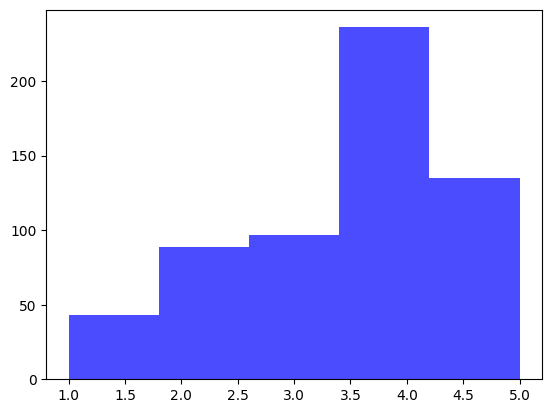

In [68]:
fig, ax = plt.subplots()
_ = ax.hist(df_vj['overall'], bins=5, color='blue', alpha=0.7)

In [69]:
# group by id and get median performance
id2overall = df_vj.groupby('id')['overall'].median().to_dict()

In [70]:
overalls = np.array([id2overall.get(id_, np.nan) for id_ in df['id']])

In [85]:
np.where(~np.isnan(overalls))[0]

array([   9,   21,   33,   42,   45,   54,   69,   80,   95,  103,  111,
        116,  121,  132,  146,  157,  161,  162,  163,  170,  175,  176,
        212,  226,  236,  245,  251,  255,  264,  269,  271,  277,  311,
        319,  324,  326,  355,  365,  368,  372,  386,  387,  389,  407,
        409,  417,  440,  441,  445,  458,  476,  477,  486,  491,  501,
        517,  525,  547,  563,  577,  578,  581,  590,  597,  599,  600,
        623,  647,  649,  650,  656,  675,  693,  702,  735,  746,  756,
        767,  770,  780,  783,  801,  803,  804,  819,  822,  834,  848,
        851,  864,  867,  868,  873,  888,  903,  920,  922,  935,  940,
        946,  966,  971,  990,  991,  992, 1003, 1004, 1005, 1018, 1025,
       1029, 1032, 1038, 1042, 1051, 1055, 1061, 1066, 1067, 1069, 1074,
       1081, 1088, 1094, 1107, 1121, 1126, 1128, 1135, 1148, 1154, 1161,
       1171, 1181, 1188, 1191, 1195, 1196, 1203, 1215, 1218, 1221, 1222,
       1224, 1242, 1244, 1252, 1276, 1293, 1294, 13

In [83]:
not_colored

array([   2,    3,    4, ..., 1569, 1570, 1571])

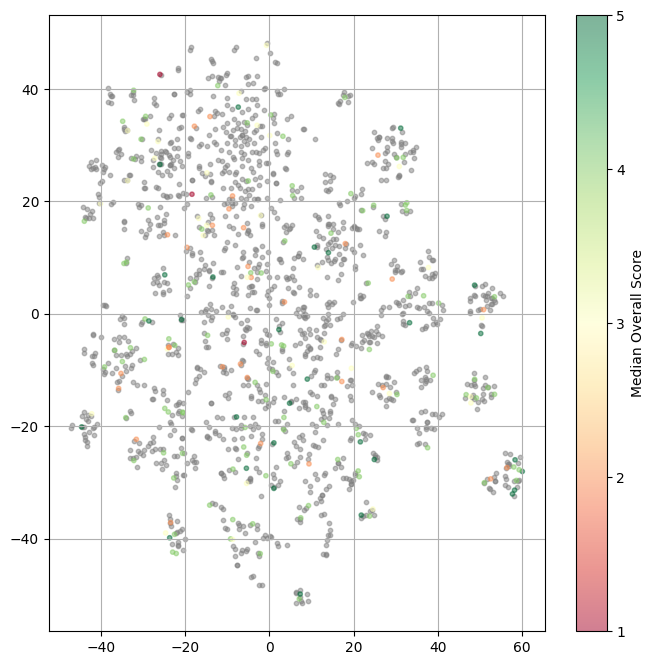

In [94]:
# plot embeddings, color-coded by median rank
fig, ax = plt.subplots(figsize=(8, 8))
colored = np.where(~np.isnan(overalls))[0]
not_colored = np.where(np.isnan(overalls))[0]
kwargs = dict(s=10, alpha=0.5)
eps = 0.5
ax.scatter(
    X_tsne[not_colored, 0]+np.random.uniform(-eps, eps, size=not_colored.shape),
    X_tsne[not_colored, 1]+np.random.uniform(-eps, eps, size=not_colored.shape), 
    c='gray',
    **kwargs
)
scatter = ax.scatter(
    X_tsne[colored, 0]+np.random.uniform(-eps, eps, size=colored.shape), 
    X_tsne[colored, 1]+np.random.uniform(-eps, eps, size=colored.shape), 
    c=overalls[colored], 
    cmap='RdYlGn',
    **kwargs
)
# add coloring bar
cbar = plt.colorbar(scatter, ax=ax)  # Associate the colorbar with the Axes
cbar.set_label('Median Overall Score')
cbar.set_ticks(np.arange(1, 6))
cbar.set_ticklabels(np.arange(1, 6))
ax.grid()

In [95]:
df_vj.head()

,factual_accuracy,completeness,relevance,hallucination,overall,justification,idx,id,question,answer_true,answer_rag
0,4,3,4,2,3,The generated answer correctly identifies the ...,0,871e39f3-ad80-413d-9353-93b39da8adf5,What is the primary function of a data connect...,A data connector (or 'Reader') ingests data fr...,A data connector (or 'Reader') ingests data fr...
1,3,3,4,3,3,The generated answer deviates significantly fr...,1,871e39f3-ad80-413d-9353-93b39da8adf5,"According to the document, what are the typica...","After data ingestion, you can build an Index, ...","After the data is loaded via a data connector,..."
2,4,3,4,5,4,The generated answer is largely accurate and d...,2,871e39f3-ad80-413d-9353-93b39da8adf5,Explain the overall purpose of using data conn...,The purpose is to take data from various sourc...,"The purpose of using data connectors is to ""in..."
3,2,2,3,3,2,The generated answer significantly expands on ...,3,45e0ab38-6280-4862-be9f-b57ce7f96492,What is the primary subject matter described i...,Relation-Based Node Parsers,An abstract modeling system that allows for ef...
4,2,2,2,3,2,The generated answer completely misinterprets ...,4,45e0ab38-6280-4862-be9f-b57ce7f96492,"Based on the title, what kind of parsing are t...",Parsing that involves relationships between no...,Text splitting or sentence splitting. The titl...


In [103]:
df_merged = df_eval.merge(
    df_vj[[
        'factual_accuracy', 'completeness', 'relevance', 'hallucination', 
        'overall', 'justification', 'answer_rag'
    ]], 
    left_index=True, 
    right_index=True
)
df_merged.groupby('cluster_tsne')['overall'].mean().sort_values()

cluster_tsne
2     2.700000
9     3.066667
17    3.066667
0     3.166667
16    3.266667
15    3.266667
12    3.466667
18    3.566667
5     3.600000
13    3.733333
10    3.733333
7     3.733333
14    3.733333
1     3.766667
6     3.766667
11    3.800000
3     3.800000
8     3.866667
4     3.900000
19    4.033333
Name: overall, dtype: float64

In [138]:
import textwrap

def print_wrapped(text, width=80):
    """Prints text wrapped to a specified width, preserving newlines."""
    for paragraph in text.splitlines():
        wrapped_lines = textwrap.wrap(paragraph, width=width)
        for line in wrapped_lines:
            print(line)

In [200]:
chunk, q, a, a_rag, overall, justification = df_merged.query('cluster_tsne == 2').sort_values(
    by='overall'
).iloc[4][['text', 'question', 'answer', 'answer_rag', 'overall', 'justification']]

In [201]:
print_wrapped(chunk)

::: llama_index.readers.azstorage_blob
    options:
      members:
        - AzStorageBlobReader


In [202]:
print_wrapped(q)

What class is described in this documentation?


In [203]:
print_wrapped(a)

The documentation describes the `AzStorageBlobReader` class.


In [204]:
print_wrapped(a_rag)

The InstructorEmbeddings class is described in this documentation.


In [205]:
overall

np.int64(1)

In [206]:
print_wrapped(justification)

The generated answer is fundamentally incorrect. It identifies
'InstructorEmbeddings' when the reference explicitly states
'AzStorageBlobReader'. This is a major factual error, rendering the answer
unusable. While it attempts to answer the question, it does so with completely
wrong information. The reference answer identifies a specific class; the
generated answer identifies a *different* class, indicating a failure in the
retrieval component of the RAG system.  The hallucination score is moderate
because it *did* identify a class name, but the class is incorrect and not found
in the reference documentation. It's plausible the retrieval brought back a
class name that *resembles* the correct one, leading to this error. This
demonstrates a serious issue with the RAG system's ability to accurately
retrieve relevant information.
